## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
import xarray as xr
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.handlers import mask
from numpyro.infer import MCMC, NUTS, Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Text(0.5, 1.0, 'Censored Gamma Sample Data')

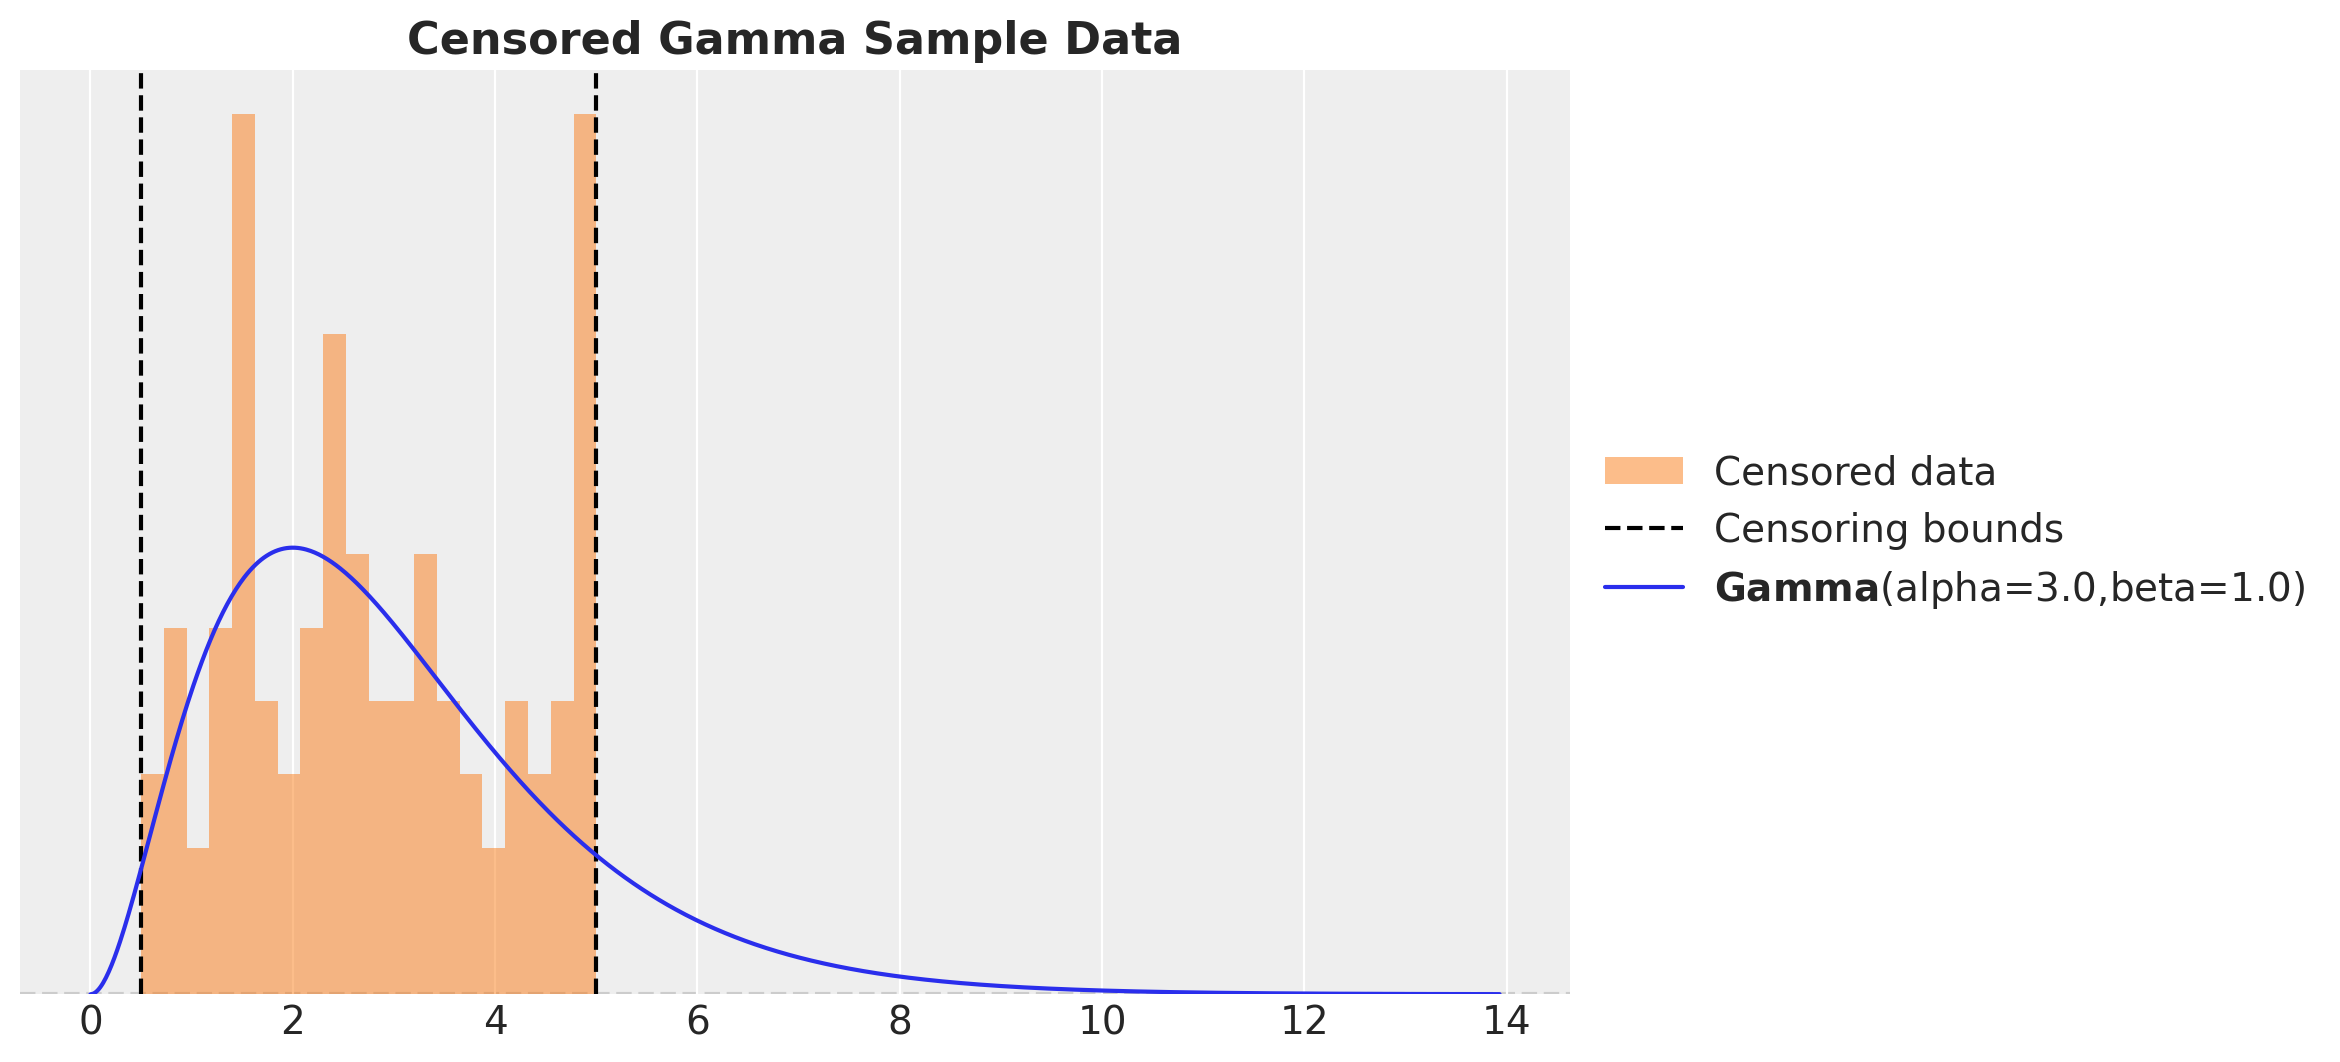

In [2]:
alpha = 3.0
beta = 1.0
lower = 0.5
upper = 5.0
n = 100


def generate_censored_gamma_samples(rng_key, alpha, beta, lower, upper, n):
    raw_samples = dist.Gamma(concentration=alpha, rate=beta).sample(rng_key, (n,))
    return jnp.clip(raw_samples, lower, upper)


rng_key, rng_subkey = random.split(rng_key)
censored_gamma_samples = generate_censored_gamma_samples(
    rng_key=rng_subkey, alpha=alpha, beta=beta, lower=lower, upper=upper, n=100
)

fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(lower, color="k", linestyle="--")
ax.axvline(upper, color="k", linestyle="--", label="Censoring bounds")
pz.Gamma(alpha=alpha, beta=beta).plot_pdf(color="C0", ax=ax)
ax.set_title("Censored Gamma Sample Data", fontsize=16, fontweight="bold")

In [3]:
def gamma_model(y: ArrayImpl) -> None:
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))
    numpyro.sample("obs", dist.Gamma(concentration=alpha, rate=beta), obs=y)


gamma_kernel = NUTS(gamma_model)
gamma_mcmc = MCMC(gamma_kernel, num_warmup=1_000, num_samples=2_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
gamma_mcmc.run(rng_key, y=censored_gamma_samples)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [4]:
gamma_predictive = Predictive(
    model=gamma_model, posterior_samples=gamma_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
gamma_posterior_predictive = gamma_predictive(rng_subkey, y=None)

gamma_idata = az.from_numpyro(posterior=gamma_mcmc)
gamma_idata.extend(az.from_numpyro(posterior_predictive=gamma_posterior_predictive))

Text(0.5, 0.98, 'Gamma Model')

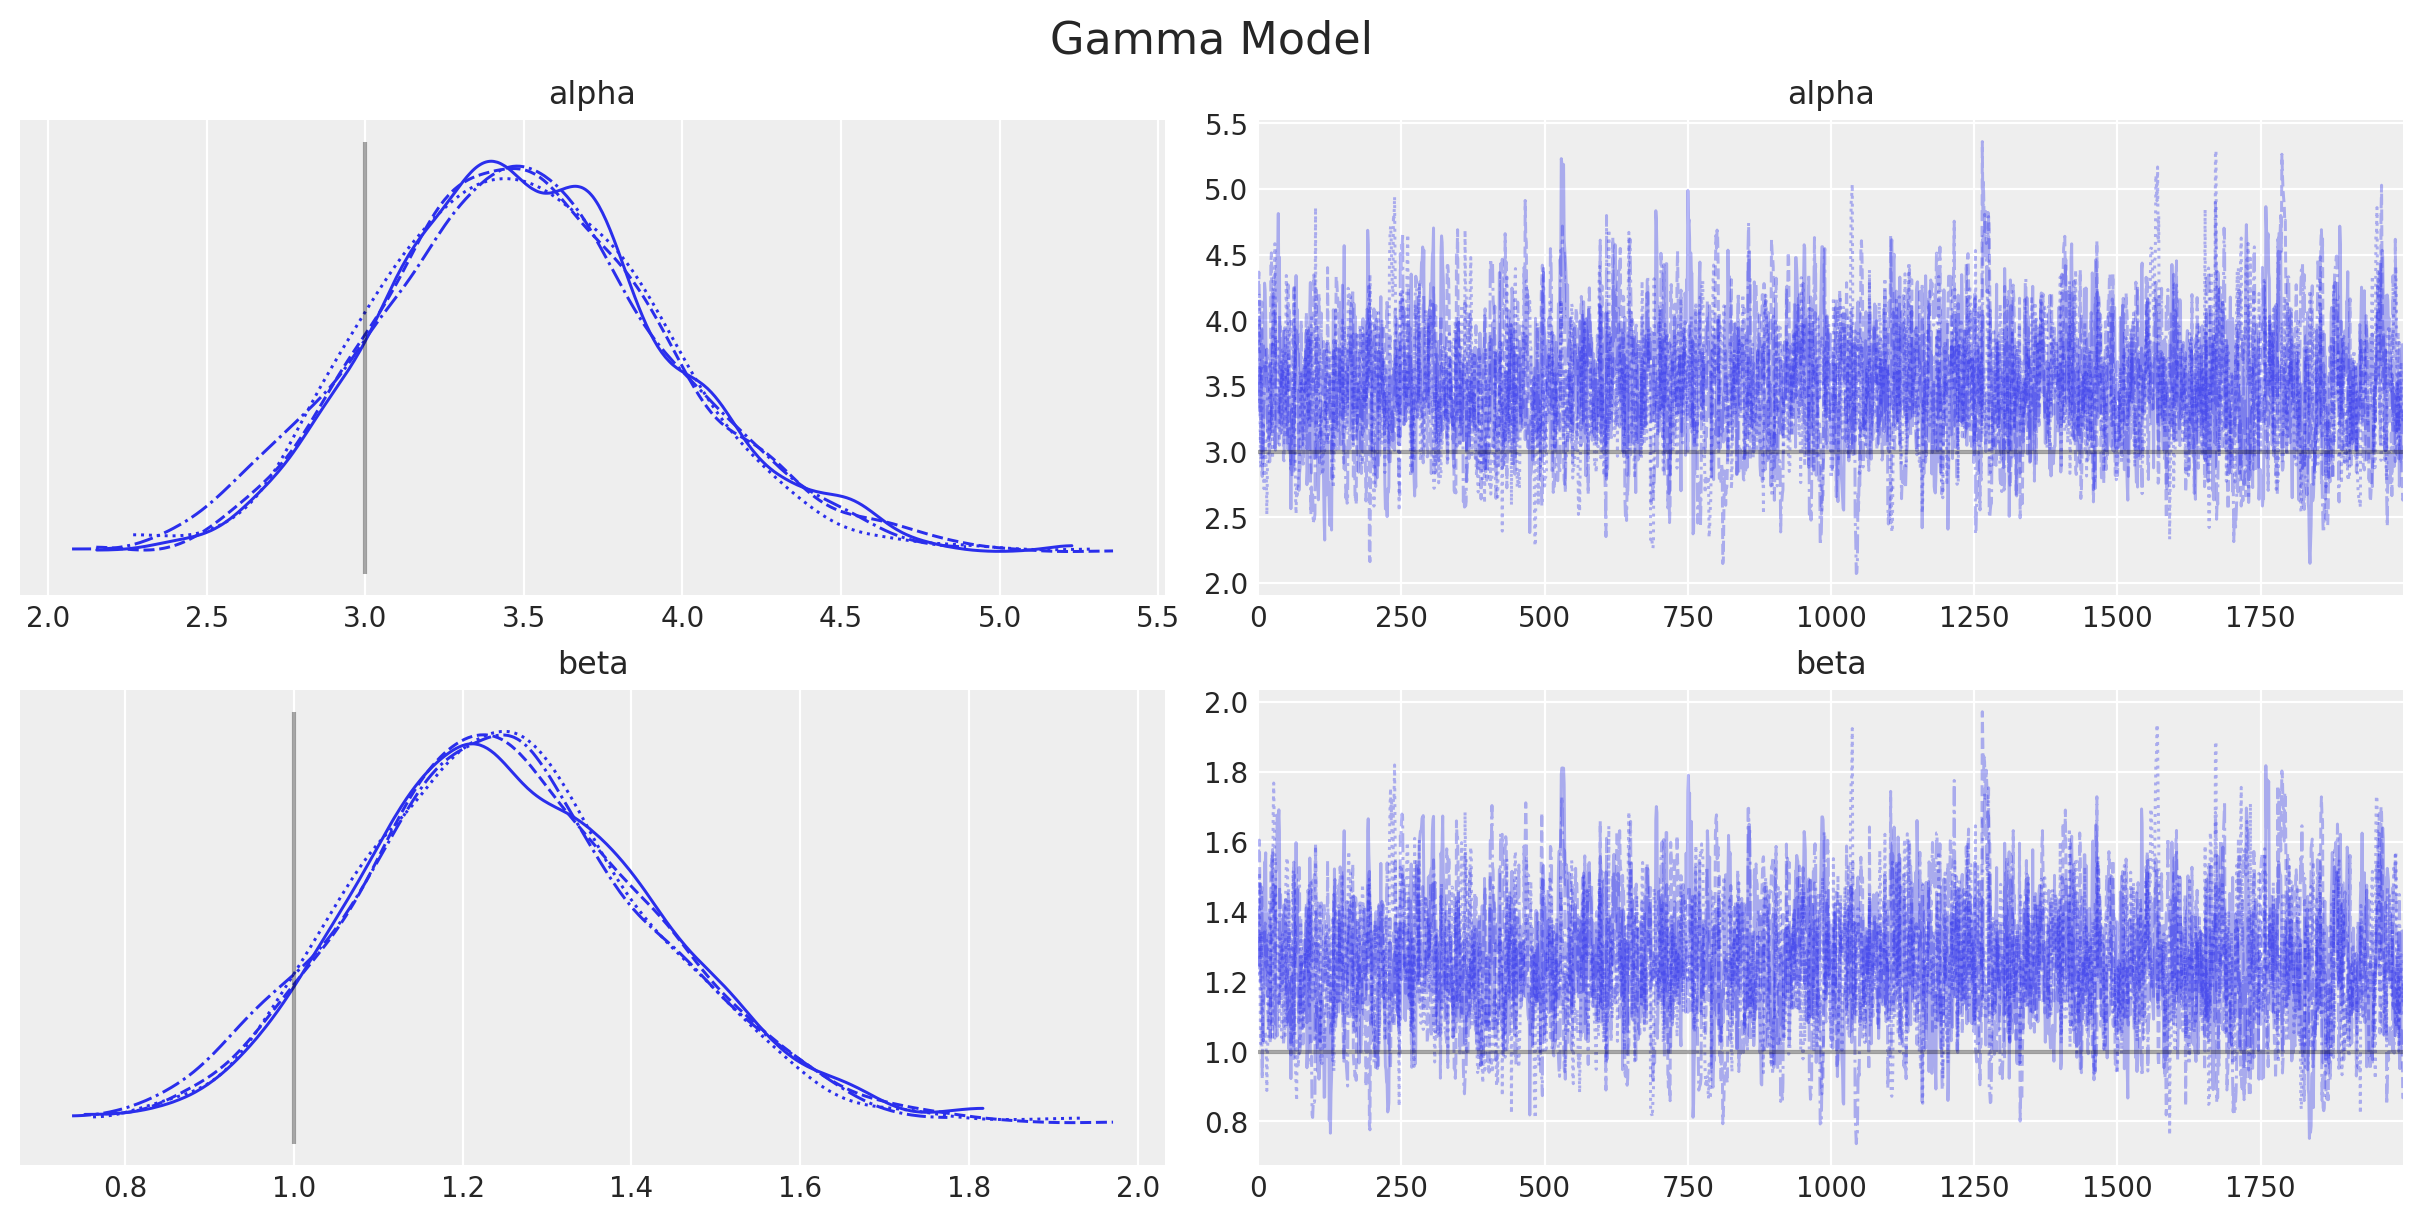

In [5]:
axes = az.plot_trace(
    data=gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, alpha),
        ("beta", {}, beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Model", fontsize=16)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

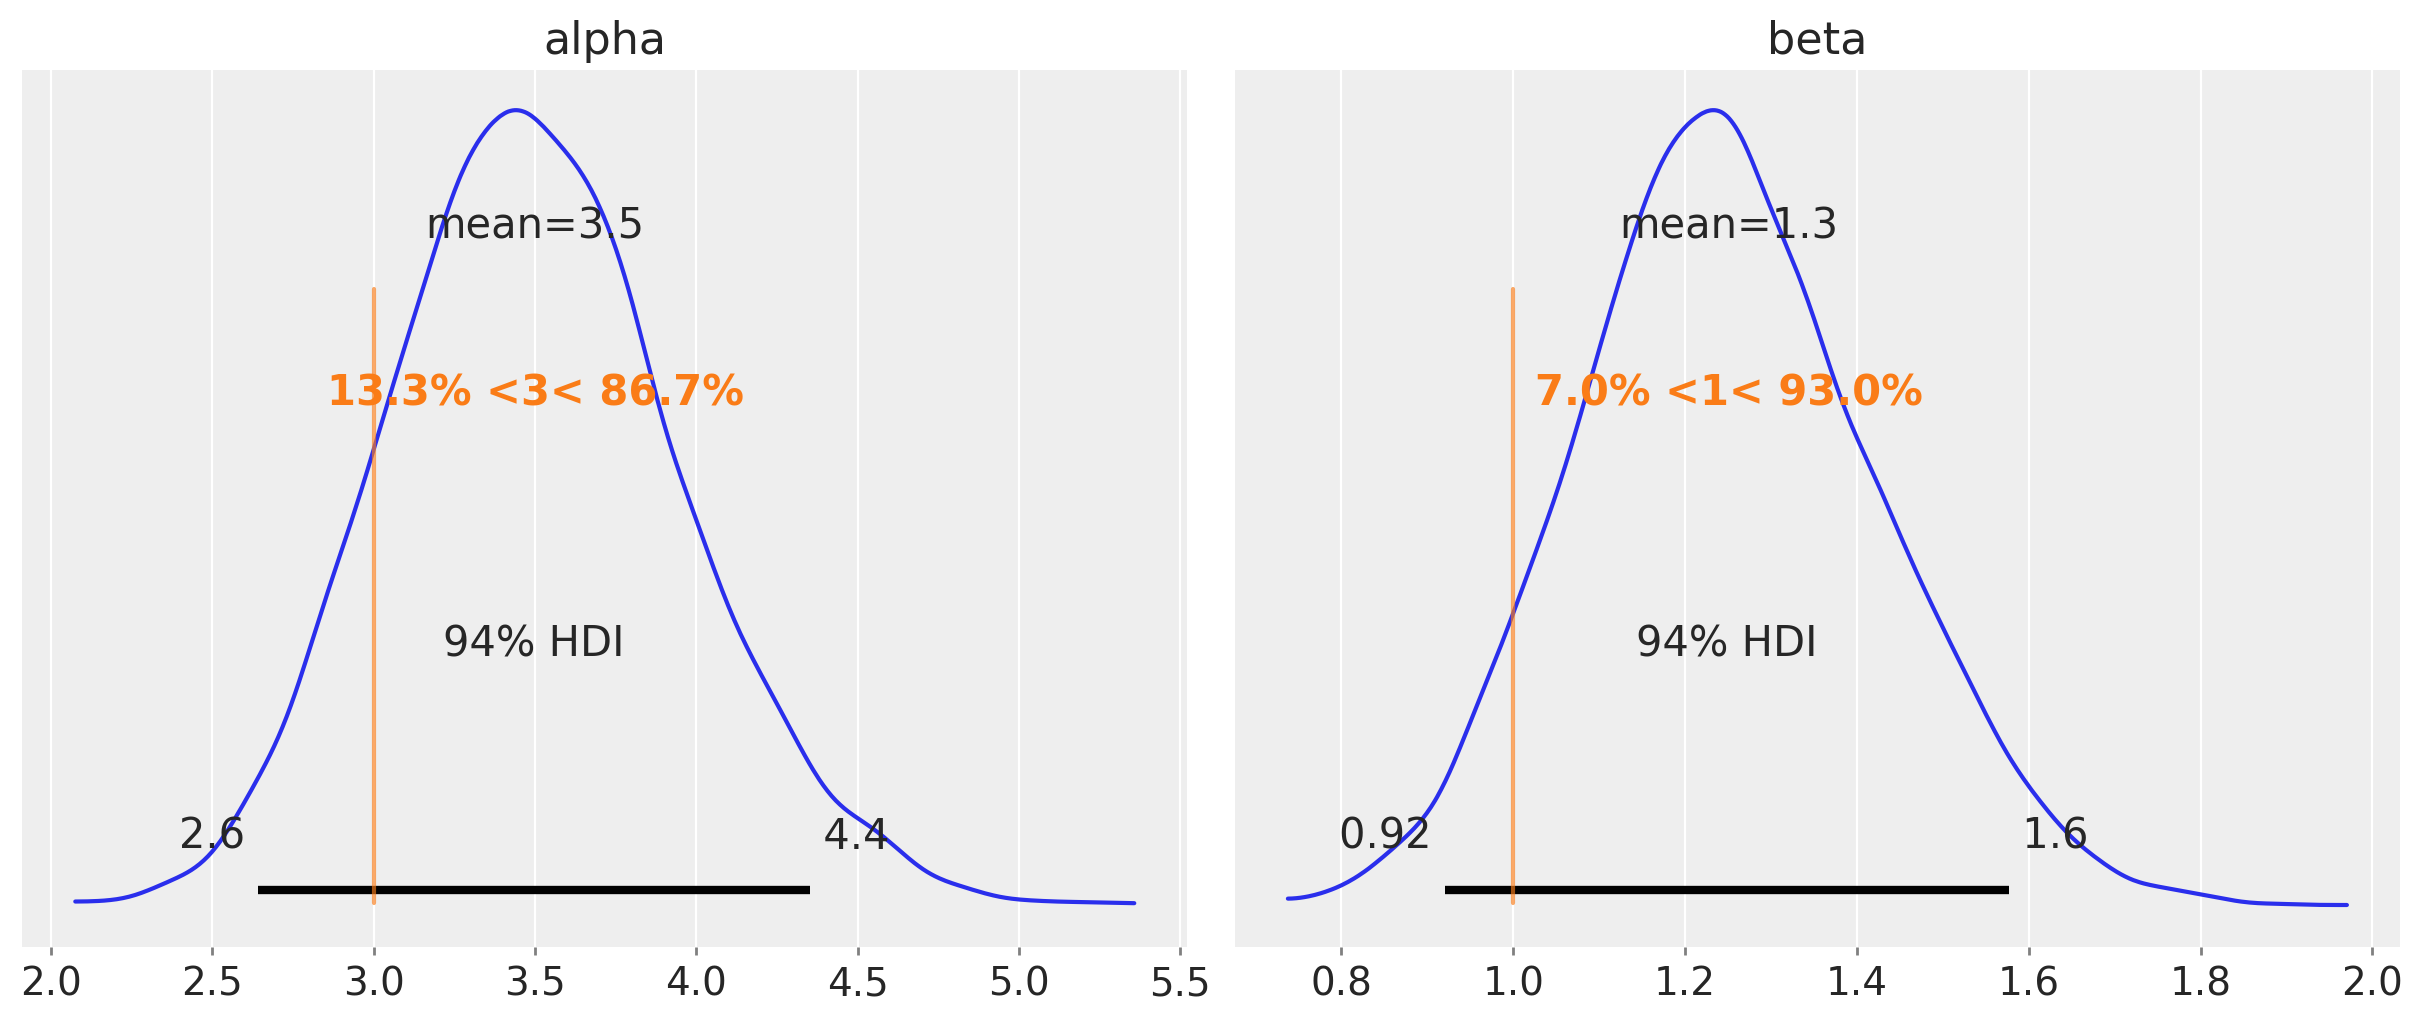

In [6]:
az.plot_posterior(
    data=gamma_idata,
    ref_val=[alpha, beta],
    round_to=2,
    figsize=(12, 5),
)

Text(0.5, 1.0, 'Gamma Model')

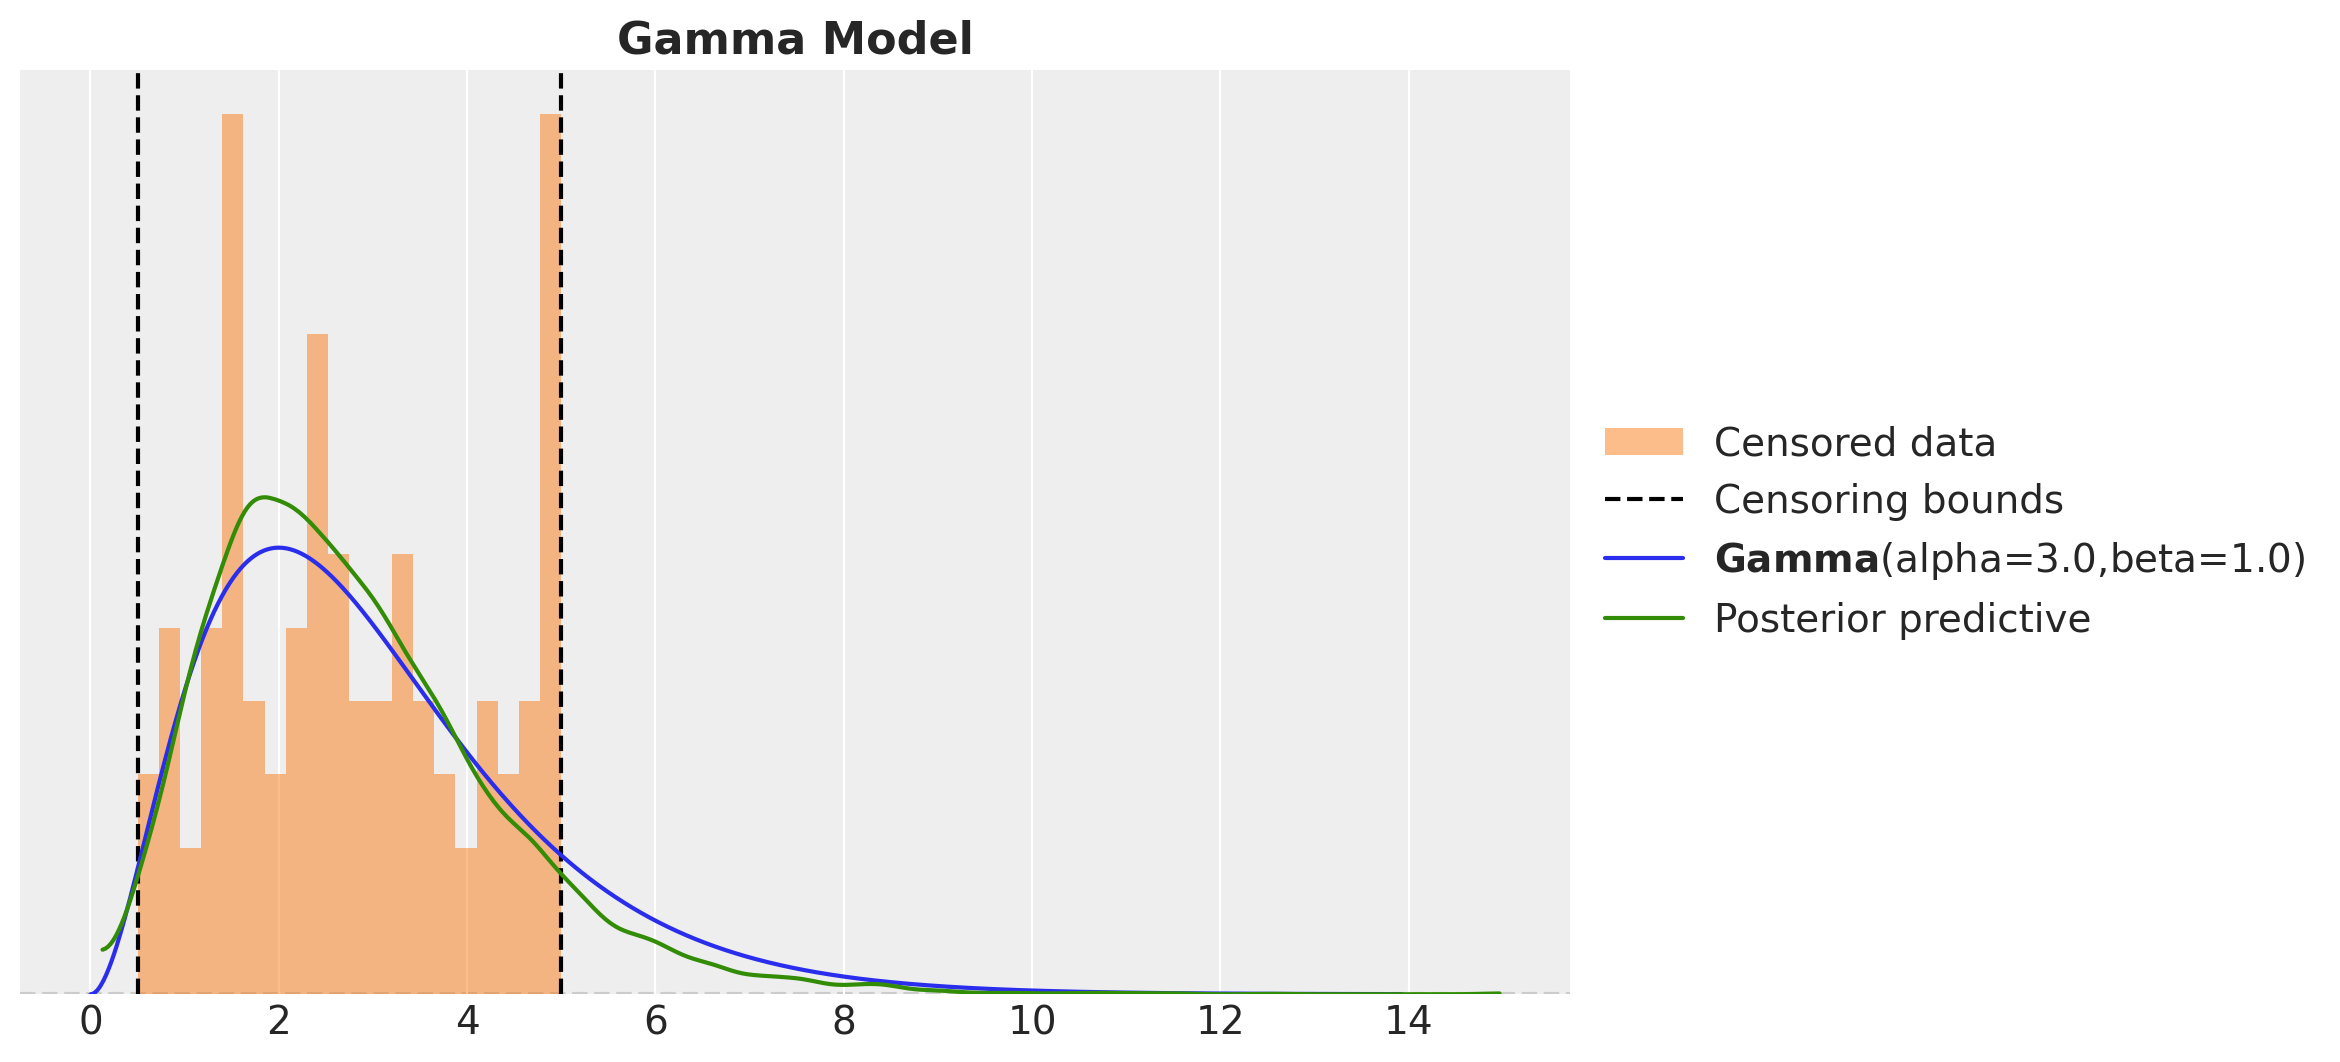

In [7]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(lower, color="k", linestyle="--")
ax.axvline(upper, color="k", linestyle="--", label="Censoring bounds")
pz.Gamma(alpha=alpha, beta=beta).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Gamma Model", fontsize=16, fontweight="bold")

In [8]:
y = censored_gamma_samples
truncation_label = jnp.where(y == lower, -1, jnp.where(y == upper, 1, 0))

In [9]:
# https://gist.github.com/hesenp/90877ea3d5801214098fecd3b9e089bc


def censored_gamma_model(
    y: ArrayImpl, lower: float, upper: float, truncation_label: ArrayImpl
) -> None:
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))

    distribution = dist.Gamma(concentration=alpha, rate=beta)

    with mask(mask=truncation_label == -1):
        truncation_prob_lower = distribution.cdf(lower)
        numpyro.sample(
            "truncated_label_lower", dist.Bernoulli(truncation_prob_lower), obs=1
        )

    with mask(mask=truncation_label == 0):
        numpyro.sample("obs", distribution, obs=y)

    with mask(mask=truncation_label == 1):
        truncation_prob_upper = 1 - distribution.cdf(upper)
        numpyro.sample(
            "truncated_label_upper", dist.Bernoulli(truncation_prob_upper), obs=1
        )

In [10]:
censored_gamma_kernel = NUTS(censored_gamma_model)
censored_gamma_mcmc = MCMC(
    censored_gamma_kernel, num_warmup=1_000, num_samples=2_000, num_chains=4
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_mcmc.run(
    rng_key,
    y=censored_gamma_samples,
    lower=lower,
    upper=upper,
    truncation_label=truncation_label,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [11]:
censored_gamma_predictive = Predictive(
    model=censored_gamma_model, posterior_samples=censored_gamma_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_posterior_predictive = censored_gamma_predictive(
    rng_subkey, y=None, lower=lower, upper=upper, truncation_label=truncation_label
)

censored_gamma_idata = az.from_numpyro(posterior=censored_gamma_mcmc)
censored_gamma_idata.extend(
    az.from_numpyro(posterior_predictive=censored_gamma_posterior_predictive)
)

Text(0.5, 0.98, 'Censored Gamma Model')

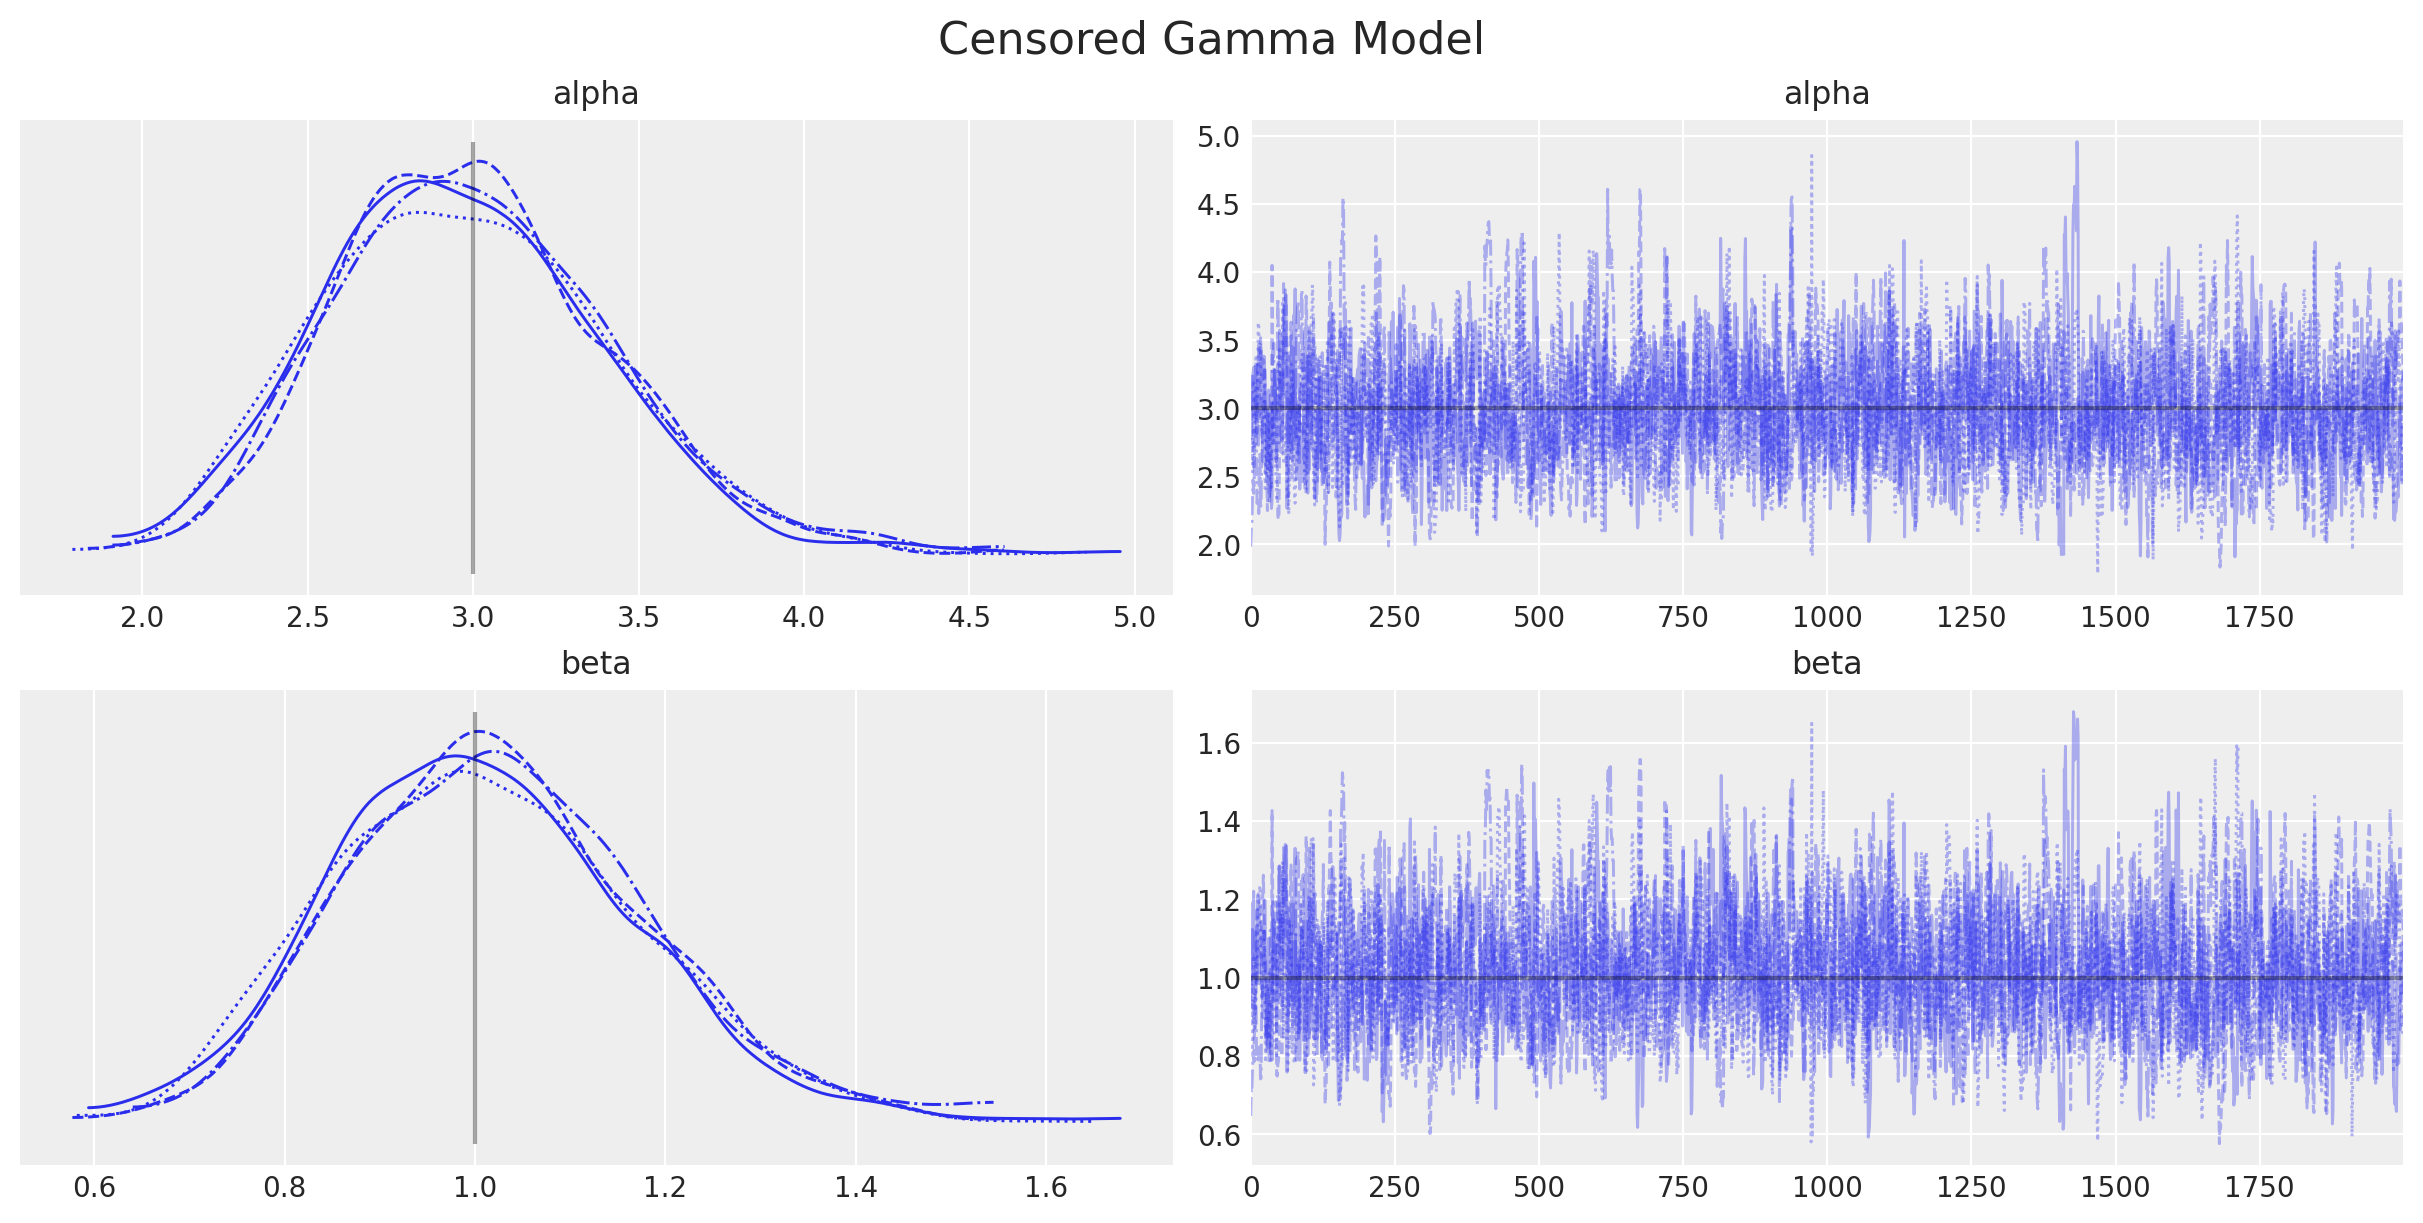

In [12]:
axes = az.plot_trace(
    data=censored_gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, alpha),
        ("beta", {}, beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Censored Gamma Model", fontsize=16)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

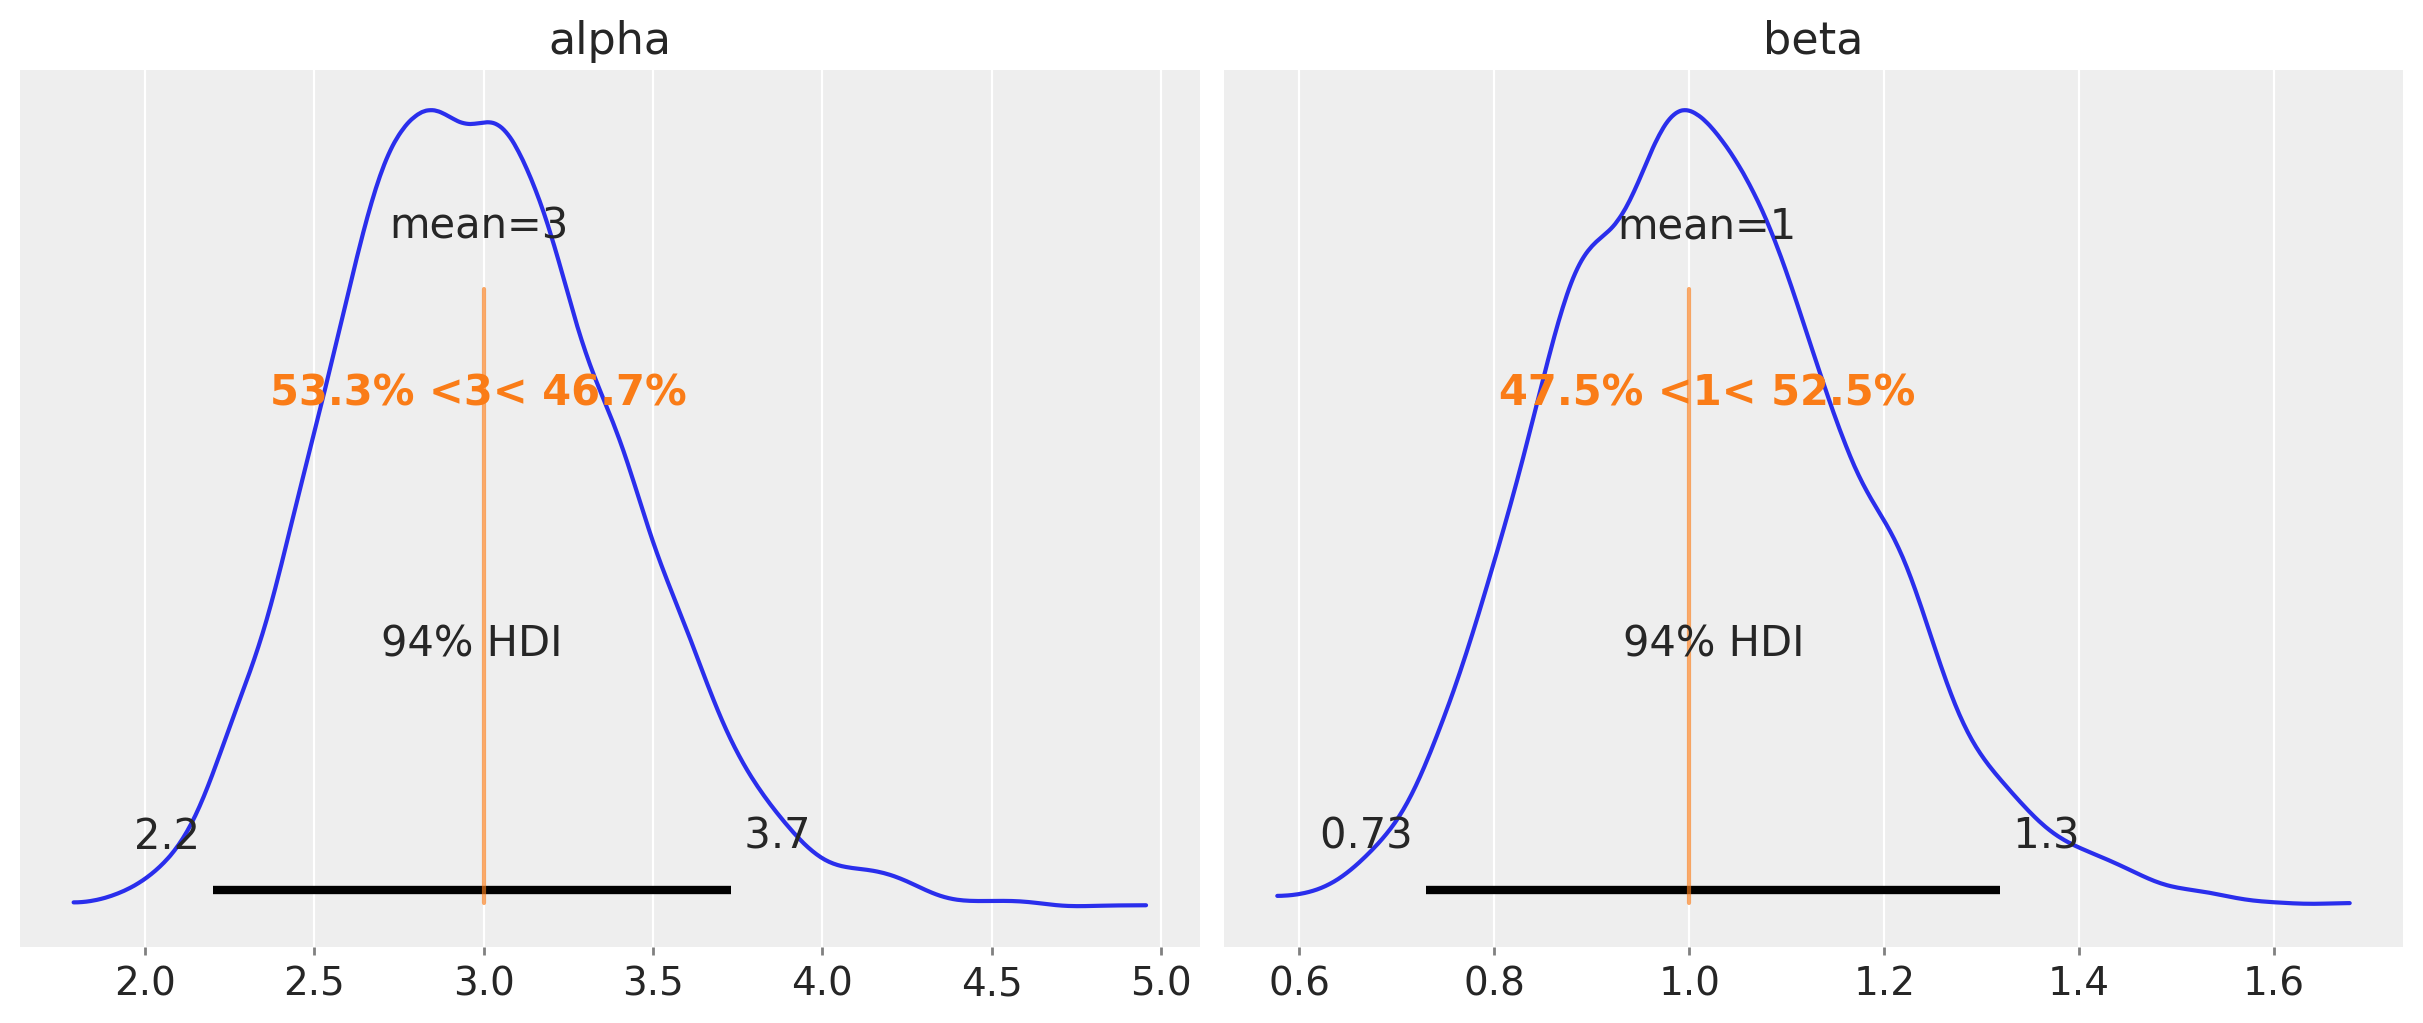

In [13]:
az.plot_posterior(
    data=censored_gamma_idata,
    ref_val=[alpha, beta],
    round_to=2,
    figsize=(12, 5),
)

Text(0.5, 1.0, 'Censored Gamma Model')

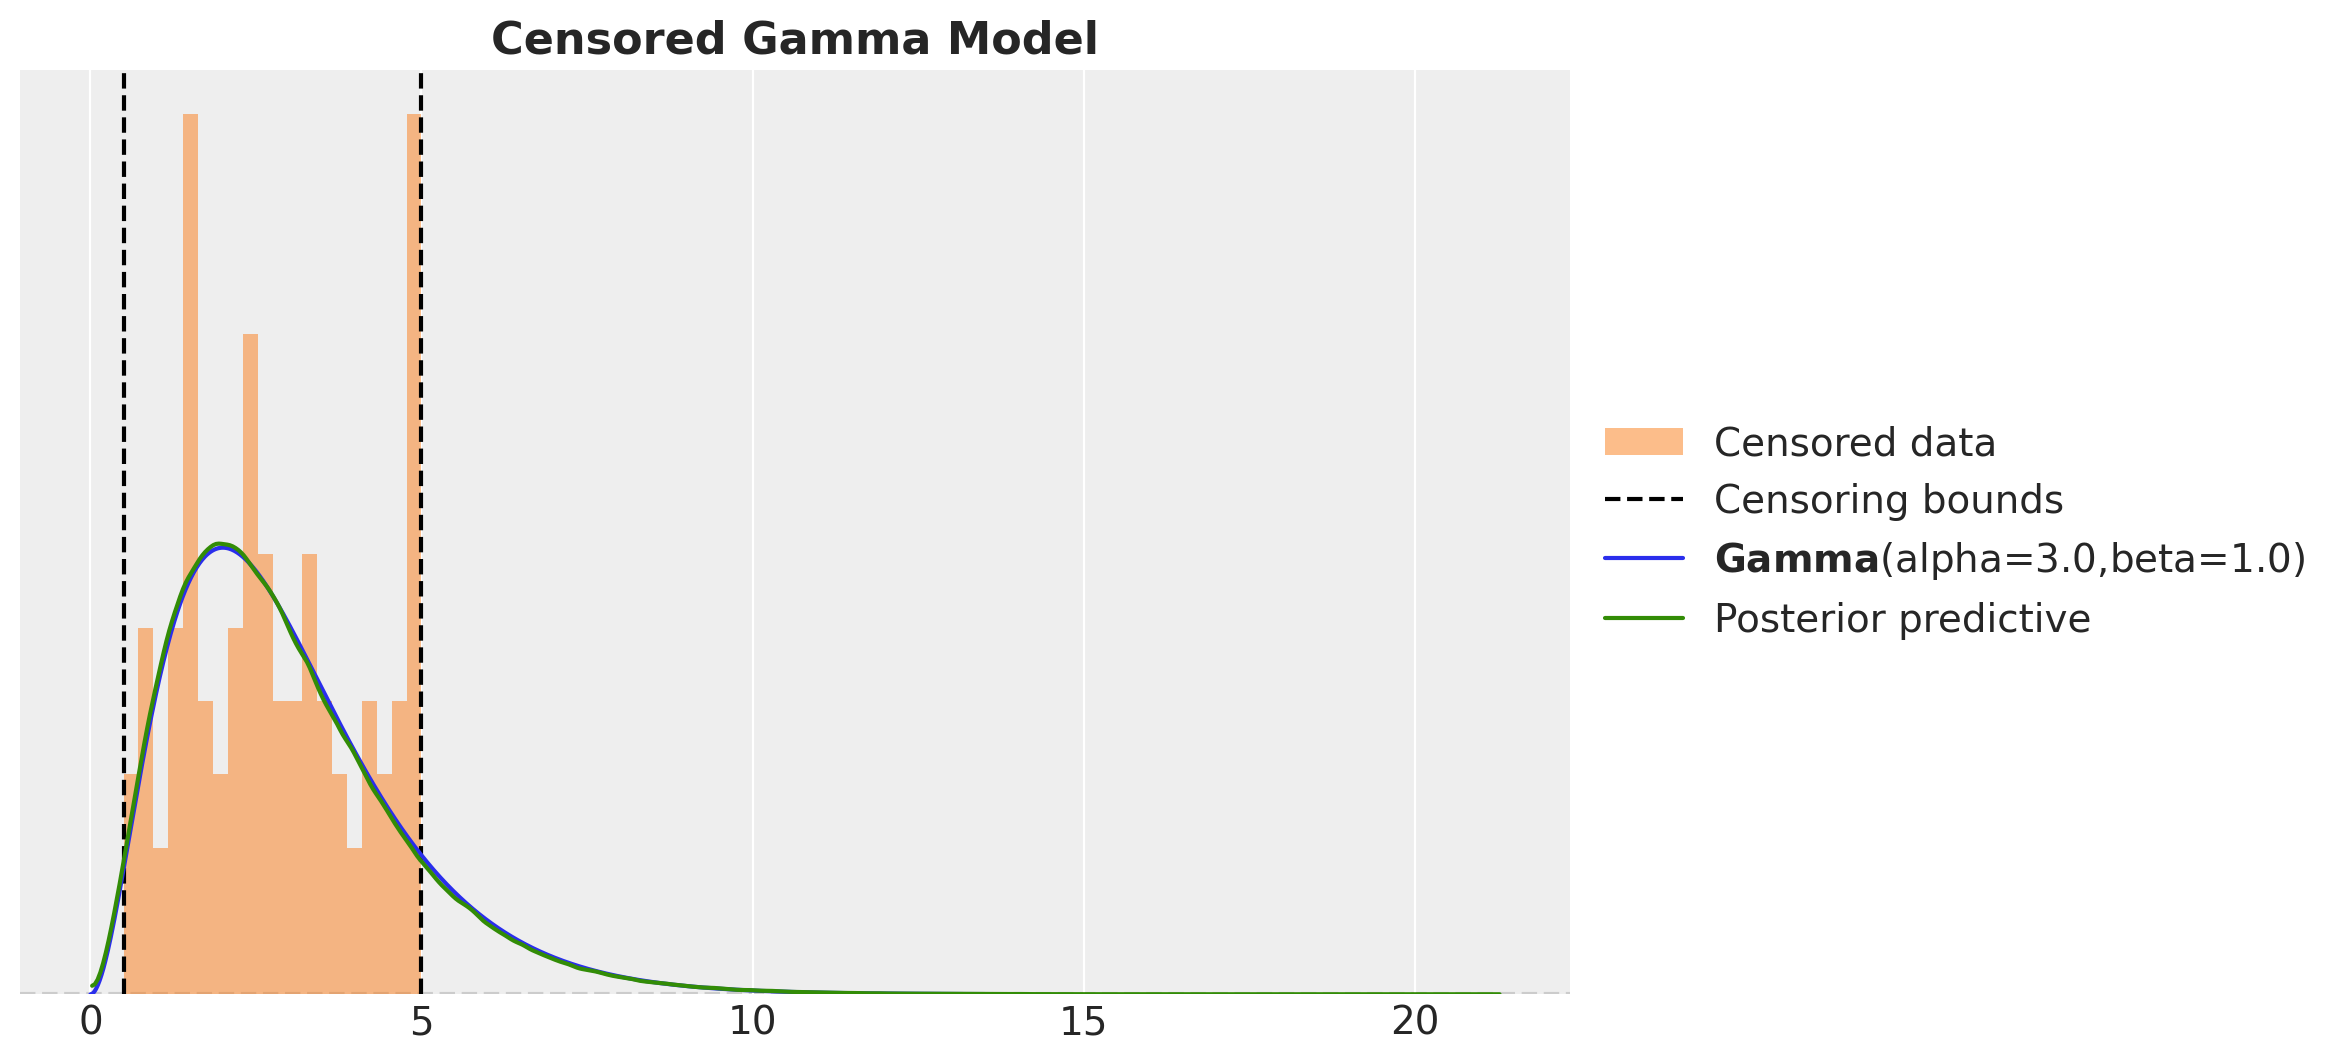

In [14]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(lower, color="k", linestyle="--")
ax.axvline(upper, color="k", linestyle="--", label="Censoring bounds")
pz.Gamma(alpha=alpha, beta=beta).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    censored_gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Gamma Model", fontsize=16, fontweight="bold")